# Import

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import time
parent_dir = os.path.abspath('..')
sys.path.insert(1, parent_dir)

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, fbeta_score

In [4]:
from tools.functions import missing_values_summary, unique_value_counts, pct_null_buckets

In [5]:
from tools import LightGBM

In [66]:
from tools.mlflow_tracking import log_model

# Exploration

In [6]:
csv_path = os.path.join(parent_dir, "data")
file_names = [f for f in os.listdir(csv_path) if f.endswith(".csv")]
file_names

['application_test.csv',
 'application_train.csv',
 'bureau.csv',
 'bureau_balance.csv',
 'credit_card_balance.csv',
 'data.csv',
 'HomeCredit_columns_description.csv',
 'installments_payments.csv',
 'POS_CASH_balance.csv',
 'previous_application.csv',
 'sample_submission.csv']

## application_test

In [ ]:
file = file_names[0]
path = os.path.join('..','data', file)
data = pd.read_csv(path)
data.head()

In [ ]:
data.info()

In [ ]:
temp = missing_values_summary(data, ascending=False)
temp

## application_train

In [ ]:
file = file_names[1]
print(file)
path = os.path.join('..','data', file)
data = pd.read_csv(path)
data.head()

In [ ]:
data.info()

In [ ]:
cols = ['SK_ID_CURR', 'TARGET']
temp = missing_values_summary(data, ascending=False)
temp[temp['index'].isin(cols)]

In [ ]:
unique_value_counts(data, 'TARGET')

In [ ]:
data['SK_ID_CURR'].nunique()

In the application_train dataset, there are 92% of the applications that are refused.

## bureau

In [ ]:
file = file_names[2]
print(file)
path = os.path.join('..','data', file)
data = pd.read_csv(path)
data.head()

In [ ]:
data.info()

In [ ]:
temp = missing_values_summary(data, ascending=False)
temp

In [ ]:
data['SK_ID_CURR'].nunique()

## bureau_balance

In [ ]:
file = file_names[3]
print(file)
path = os.path.join('..','data', file)
data = pd.read_csv(path)
data.head()

In [ ]:
data.info()

In [ ]:
temp = missing_values_summary(data, ascending=False)
temp

## credit_card_balance

In [ ]:
file = file_names[4]
print(file)
path = os.path.join('..','data', file)
data = pd.read_csv(path)
data.head()

In [ ]:
data.info()

In [ ]:
temp = missing_values_summary(data, ascending=False)
temp

## HomeCredit_columns_description

In [ ]:
file = file_names[5]
print(file)
path = os.path.join('..','data', file)
data = pd.read_csv(path, encoding = 'unicode_escape')
data.head()

In [ ]:
data.info()

In [ ]:
temp = missing_values_summary(data, ascending=False)
temp

## installments_payments

In [ ]:
file = file_names[6]
print(file)
path = os.path.join('..','data', file)
data = pd.read_csv(path)
data.head()

In [ ]:
data.info()

In [ ]:
temp = missing_values_summary(data, ascending=False)
temp

## POS_CASH_balance

In [ ]:
file = file_names[7]
print(file)
path = os.path.join('..','data', file)
data = pd.read_csv(path)
data.head()

In [ ]:
data.info()

In [ ]:
temp = missing_values_summary(data, ascending=False)
temp

## previous_application

In [ ]:
file = file_names[8]
print(file)
path = os.path.join('..','data', file)
data = pd.read_csv(path)
data.head()

In [ ]:
data.info()

In [ ]:
temp = missing_values_summary(data, ascending=False)
temp

## sample_submission

In [ ]:
file = file_names[9]
print(file)
path = os.path.join('..','data', file)
data = pd.read_csv(path)
data.head()

In [ ]:
data.info()

In [ ]:
temp = missing_values_summary(data, ascending=False)
temp

In [ ]:
data['TARGET'].value_counts()

# Data preprocessing

In [6]:
parent_dir = os.path.abspath('..')
sys.path.insert(1, parent_dir)
file_path = os.path.join(parent_dir, "data", "data.csv")

In [37]:
# data = LightGBM.main()
# data.to_csv(file_path, index=False)

Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 35s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 44s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 23s
Installments payments df shape: (339587, 26)
Process installments payments - done in 54s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 30s


In [7]:
data = pd.read_csv(file_path)
data.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,100002,1,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,100007,0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Missing data

<AxesSubplot: xlabel='Percentage_Null', ylabel='Count'>

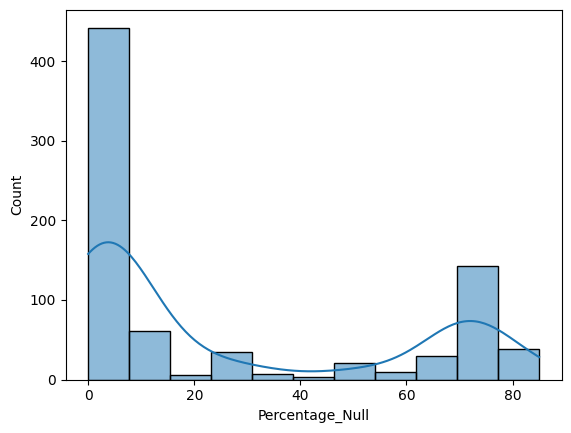

In [8]:
temp = missing_values_summary(data, ascending=False)
temp['Percentage_Null'] = temp['Percentage_Null'].apply(lambda x: round(x,0))
sns.histplot(temp['Percentage_Null'], kde=True)

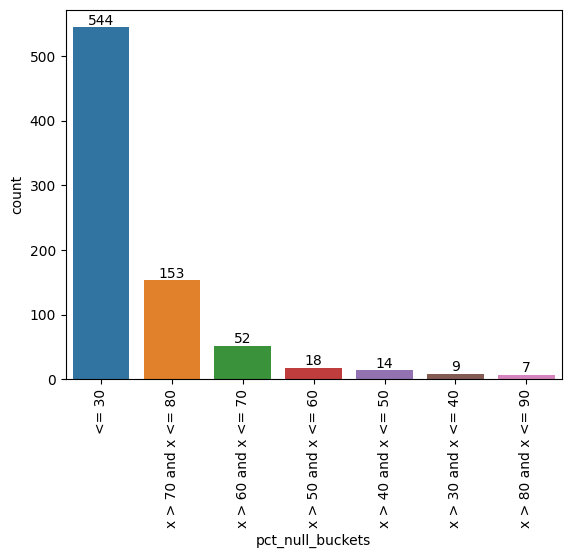

In [9]:
temp['pct_null_buckets'] = temp['Percentage_Null'].apply(lambda x: pct_null_buckets(x))

ax = sns.countplot(x=temp['pct_null_buckets'],
                   order=temp['pct_null_buckets'].value_counts(ascending=False).index)
abs_values = temp['pct_null_buckets'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)
plt.xticks(rotation=90);

In [10]:
cols_to_drop = list(temp[temp['Percentage_Null'] > 30]['index'])
cols = list(data.columns)
cols_to_keep = [col for col in cols if col not in cols_to_drop]

print(len(cols_to_drop))
print(len(cols))
print(len(cols_to_keep))

253
797
544


In [11]:
df = data.copy()
df = df[cols_to_keep]
df.shape

(307507, 544)

## Descriptive statistics

In [12]:
temp = df.describe()
temp.loc['max'].max()

inf

In [13]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [14]:
temp = df.describe()
temp.loc['max'].max()

445993643959.2246

In [15]:
missing_values_summary(df, ascending=False)

,index,Null_counts,Non_Null_counts,Percentage_Null
255,ACTIVE_AMT_CREDIT_SUM_MAX,90362,217145,29.385347
256,ACTIVE_AMT_CREDIT_SUM_MEAN,90362,217145,29.385347
260,ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM,90361,217146,29.385022
262,ACTIVE_MONTHS_BALANCE_SIZE_SUM,90361,217146,29.385022
249,ACTIVE_DAYS_CREDIT_MIN,90361,217146,29.385022
...,...,...,...,...
134,ORGANIZATION_TYPE_Government,0,307507,0.000000
133,ORGANIZATION_TYPE_Emergency,0,307507,0.000000
132,ORGANIZATION_TYPE_Electricity,0,307507,0.000000
131,ORGANIZATION_TYPE_Culture,0,307507,0.000000


## Data

In [16]:
X = df.drop(columns=['TARGET'])
y = df['TARGET']

# Simulation

## Dummy

In [18]:
imputer = SimpleImputer(strategy="mean")
imputer.fit(X)
X_imputer = imputer.transform(X)

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_imputer, y)
dummy.predict(X_imputer)
dummy.score(X_imputer, y)

# from mlflow import log_metric,
# log_metric("dummy_accuracy", dummy.score(X_imputer, y))

## LGBM

In [48]:
pipe = Pipeline([
    ('imputer', SimpleImputer()),
    ('smote', SMOTE()),
    ('model', LGBMClassifier()),
])

grid = {
    'imputer__strategy': ["mean"],
    'smote__sampling_strategy': [0.1],
    'model__n_estimators': [100]
}

scorers = {
    'score_accuracy': 'accuracy',
    'score_roc_auc': 'roc_auc',
    'score_fbeta': make_scorer(fbeta_score, beta=0.5, greater_is_better=False)
}

search = GridSearchCV(pipe, grid, scoring=scorers, refit='score_fbeta', cv=5, n_jobs=-1)
search.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('smote', SMOTE()),
                                       ('model', LGBMClassifier())]),
             n_jobs=-1,
             param_grid={'imputer__strategy': ['mean'],
                         'model__n_estimators': [100],
                         'smote__sampling_strategy': [0.1]},
             refit='score_fbeta',
             scoring={'score_accuracy': 'accuracy',
                      'score_fbeta': make_scorer(fbeta_score, beta=0.5),
                      'score_roc_auc': 'roc_auc'})

In [69]:
# MLflow
log_model(search)

2023/01/20 18:51:21 INFO mlflow.tracking.fluent: Experiment with name 'LGBMClassifier()_Fri-Jan-20-18:51:21-2023' does not exist. Creating a new experiment.


Run is logged


In [62]:
y_pred_prob = search.predict_proba(X)
y_pred_prob

array([[0.77352165, 0.22647835],
       [0.98655735, 0.01344265],
       [0.94348043, 0.05651957],
       ...,
       [0.92373581, 0.07626419],
       [0.9339073 , 0.0660927 ],
       [0.8778682 , 0.1221318 ]])

## Catboost

In [72]:
pipe = Pipeline([
    ('imputer', SimpleImputer()),
    ('smote', SMOTE()),
    ('model', CatBoostClassifier()),
])

grid = {
    'imputer__strategy': ["mean"],
    'smote__sampling_strategy': [0.1],
    'model__n_estimators': [100]
}

scorers = {
    'score_accuracy': 'accuracy',
    'score_roc_auc': 'roc_auc',
    'score_fbeta': make_scorer(fbeta_score, beta=0.5, greater_is_better=False)
}

search = GridSearchCV(pipe, grid, scoring=scorers, refit='score_fbeta', cv=5, n_jobs=-1)
search.fit(X, y)

Learning rate set to 0.5
0:	learn: 0.3685137	total: 564ms	remaining: 55.8s
1:	learn: 0.2984781	total: 999ms	remaining: 48.9s
2:	learn: 0.2765660	total: 1.5s	remaining: 48.4s
3:	learn: 0.2652020	total: 1.93s	remaining: 46.4s
4:	learn: 0.2586937	total: 2.31s	remaining: 43.9s
5:	learn: 0.2551739	total: 2.73s	remaining: 42.7s
6:	learn: 0.2530006	total: 3.28s	remaining: 43.6s
7:	learn: 0.2505423	total: 3.83s	remaining: 44s
8:	learn: 0.2494078	total: 4.2s	remaining: 42.5s
9:	learn: 0.2481164	total: 4.65s	remaining: 41.8s
10:	learn: 0.2465387	total: 5.12s	remaining: 41.4s
11:	learn: 0.2458942	total: 5.5s	remaining: 40.4s
12:	learn: 0.2453789	total: 5.9s	remaining: 39.5s
13:	learn: 0.2448555	total: 6.42s	remaining: 39.4s
14:	learn: 0.2444693	total: 6.8s	remaining: 38.5s
15:	learn: 0.2432717	total: 7.38s	remaining: 38.7s
16:	learn: 0.2426832	total: 7.78s	remaining: 38s
17:	learn: 0.2422207	total: 8.18s	remaining: 37.3s
18:	learn: 0.2419660	total: 8.64s	remaining: 36.8s
19:	learn: 0.2416337	tota

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('smote', SMOTE()),
                                       ('model',
                                        <catboost.core.CatBoostClassifier object at 0x000001C23870B9A0>)]),
             n_jobs=-1,
             param_grid={'imputer__strategy': ['mean'],
                         'model__n_estimators': [100],
                         'smote__sampling_strategy': [0.1]},
             refit='score_fbeta',
             scoring={'score_accuracy': 'accuracy',
                      'score_fbeta': make_scorer(fbeta_score, greater_is_better=False, beta=0.5),
                      'score_roc_auc': 'roc_auc'})

In [73]:
# MLflow
log_model(search)

2023/01/20 19:12:20 INFO mlflow.tracking.fluent: Experiment with name '<catboost.core.CatBoostClassifier object at 0x000001C23870B9A0>_Fri-Jan-20-19:12:18-2023' does not exist. Creating a new experiment.


Run is logged


## RandomForest

In [76]:
pipe = Pipeline([
    ('imputer', SimpleImputer()),
    ('smote', SMOTE()),
    ('model', RandomForestClassifier()),
])

grid = {
    'imputer__strategy': ["mean"],
    'smote__sampling_strategy': [0.1],
    'model__n_estimators': [100]
}

scorers = {
    'score_accuracy': 'accuracy',
    'score_roc_auc': 'roc_auc',
    'score_fbeta': make_scorer(fbeta_score, beta=0.5, greater_is_better=False)
}

search = GridSearchCV(pipe, grid, scoring=scorers, refit='score_fbeta', cv=5, n_jobs=-1)
search.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('smote', SMOTE()),
                                       ('model', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'imputer__strategy': ['mean'],
                         'model__n_estimators': [100],
                         'smote__sampling_strategy': [0.1]},
             refit='score_fbeta',
             scoring={'score_accuracy': 'accuracy',
                      'score_fbeta': make_scorer(fbeta_score, greater_is_better=False, beta=0.5),
                      'score_roc_auc': 'roc_auc'})

In [77]:
# MLflow
log_model(search)

2023/01/20 19:40:33 INFO mlflow.tracking.fluent: Experiment with name 'RandomForestClassifier()_Fri-Jan-20-19:40:31-2023' does not exist. Creating a new experiment.


Run is logged
